<a href="https://colab.research.google.com/github/TheHappyBaloney/Brewing-Perfection/blob/main/CoffeeCherryRipeness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Import

In [42]:
import numpy as nm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import json

print("Import Successful!")

Import Successful!


In [5]:
# prompt: Mount dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls /content/drive/MyDrive/CoffeeFruitMaturity

data.yaml  README.dataset.txt  test  train  valid


In [7]:
# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data Loading and Declarations

In [21]:
train_dir = "/content/drive/MyDrive/CoffeeFruitMaturity/train"
train_dir_img = "/content/drive/MyDrive/CoffeeFruitMaturity/train/images"
train_dir_lbl = "/content/drive/MyDrive/CoffeeFruitMaturity/train/labels"

In [22]:
img_size = 128
class_size = 5
batch_size = 32

# Build a Custom Data Generator

In [24]:
def CustomDataGenerator(img_dir, lbl_dir, img_size):
    data = []
    image_files = os.listdir(img_dir)  # List all image files in the directory

    for image_file in image_files:
        # Process the image
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(lbl_dir, label_file)

        img_path = os.path.join(img_dir, image_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image {img_path} not found.")
            continue

        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Initialize a list to store centroids and class indices
        all_cherries_centroids = []

        # Read and process the label file
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()

            for line in lines:
                parts = line.strip().split()

                if len(parts) < 5:
                    continue

                class_index = int(parts[0])
                coordinates = []

                for i in range(1, len(parts), 2):
                    x = float(parts[i])
                    y = float(parts[i + 1])
                    coordinates.append((x, y))

                # Calculate centroid (average) of coordinates
                num_points = len(coordinates)
                if num_points > 0:
                    sum_x = sum(coord[0] for coord in coordinates)
                    sum_y = sum(coord[1] for coord in coordinates)
                    centroid_x = sum_x / num_points
                    centroid_y = sum_y / num_points
                else:
                    centroid_x = 0.0
                    centroid_y = 0.0

                all_cherries_centroids.append({
                    'class_index': class_index,
                    'centroid_x': centroid_x,
                    'centroid_y': centroid_y
                })

        data.append((img, all_cherries_centroids))

    return data

data = CustomDataGenerator(train_dir_img, train_dir_lbl, img_size)

## Save and Proceed

In [47]:
def save_processed_data(data, save_dir):

    for i, (img, centroids) in enumerate(data):
        img_filename = f"image_{i}.jpg"
        json_filename = f"image_{i}.json"

        img_save_path = os.path.join(save_dir,"images", img_filename)
        json_save_path = os.path.join(save_dir,"labels", json_filename)

        cv2.imwrite(img_save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        with open(json_save_path, 'w') as json_file:
            json.dump(centroids, json_file)

        print(f"Processed and saved: {img_filename} and {json_filename}")

# Define the save directory
save_dir = "/content/drive/MyDrive/CoffeeFruitMaturity/Processed"

data = CustomDataGenerator(train_dir_img, train_dir_lbl, img_size)

# Save the processed data
save_processed_data(data, save_dir)

Processed and saved: image_0.jpg and image_0.json
Processed and saved: image_1.jpg and image_1.json
Processed and saved: image_2.jpg and image_2.json
Processed and saved: image_3.jpg and image_3.json
Processed and saved: image_4.jpg and image_4.json
Processed and saved: image_5.jpg and image_5.json
Processed and saved: image_6.jpg and image_6.json
Processed and saved: image_7.jpg and image_7.json
Processed and saved: image_8.jpg and image_8.json
Processed and saved: image_9.jpg and image_9.json
Processed and saved: image_10.jpg and image_10.json
Processed and saved: image_11.jpg and image_11.json
Processed and saved: image_12.jpg and image_12.json
Processed and saved: image_13.jpg and image_13.json
Processed and saved: image_14.jpg and image_14.json
Processed and saved: image_15.jpg and image_15.json
Processed and saved: image_16.jpg and image_16.json
Processed and saved: image_17.jpg and image_17.json
Processed and saved: image_18.jpg and image_18.json
Processed and saved: image_19.jp

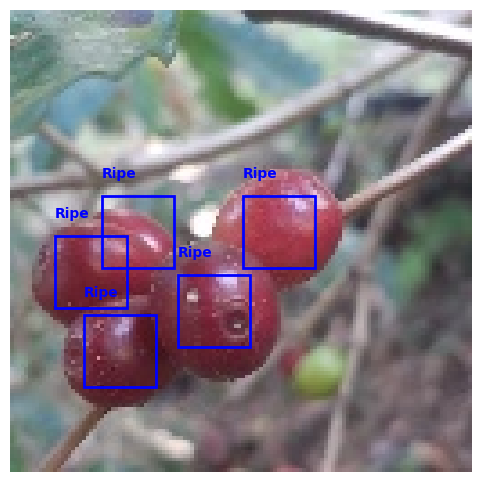

In [54]:
# Function to plot image with bounding boxes
def plot_image_with_boxes(image_path, json_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image {image_path} not found.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the JSON file
    with open(json_path, 'r') as file:
        all_cherries_centroids = json.load(file)

    class_labels = {
        0: "Dry",
        1: "Overripe",
        2: "Ripe",
        3: "Semi_ripe",
        4: "Unripe"
    }

    # Overlay bounding boxes on image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')

    for cherry in all_cherries_centroids:
        class_index = cherry['class_index']
        centroid_x = cherry['centroid_x'] * image.shape[1]
        centroid_y = cherry['centroid_y'] * image.shape[0]

        # Define bounding box parameters (adjust as needed)
        box_width = 20
        box_height = 20
        xmin = int(centroid_x - box_width / 2)
        ymin = int(centroid_y - box_height / 2)
        xmax = int(centroid_x + box_width / 2)
        ymax = int(centroid_y + box_height / 2)

        # Draw rectangle
        rect = plt.Rectangle((xmin, ymin), box_width, box_height, linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)

        # Annotate class index
        label = class_labels.get(class_index, 'Unknown')
        plt.text(xmin, ymin - 5, label, color='blue', fontsize=10, weight='bold')

    plt.show()

# Path to the saved image and JSON files
image_path = "/content/drive/MyDrive/CoffeeFruitMaturity/Processed/images/image_55.jpg"
json_path = "/content/drive/MyDrive/CoffeeFruitMaturity/Processed/labels/image_55.json"

# Plot the image with bounding boxes
plot_image_with_boxes(image_path, json_path)


## Build Model and Proceed

In [55]:
train_generator = CustomDataGenerator(
    img_dir="/content/drive/MyDrive/CoffeeFruitMaturity/train/images",
    lbl_dir="/content/drive/MyDrive/CoffeeFruitMaturity/train/labels",
    img_size=128,
)

val_generator = CustomDataGenerator(
    img_dir="/content/drive/MyDrive/CoffeeFruitMaturity/valid/images",
    lbl_dir="/content/drive/MyDrive/CoffeeFruitMaturity/valid/labels",
    img_size=128,
)

In [56]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 classes for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])